In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from pandas import json_normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [8]:
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 50)


In [9]:
# Define constants variables
PATH_OPEN_DATA = "../open-data/data/"
PATH_OPEN_DATA = "/Users/thomassinapi/Desktop/TStats/UPPSALA/open-data/data/"

### 1. **<ins>Extract competitions name</ins>**

Firstly, we extract from JSON files the names of the competitions and their respective seasons

In [10]:
# Load competitions data
with open(PATH_OPEN_DATA + "competitions.json") as f:
    data = json.load(f)

In [11]:
df = json_normalize(data, sep="_")
df.sort_values(by="season_id", inplace=True)

df.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
38,11,1,Spain,La Liga,male,False,False,2017/2018,2023-07-24T13:03:48.574627,2021-06-13T16:17:31.694,None,2023-07-24T13:03:48.574627
2,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
3,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
39,11,2,Spain,La Liga,male,False,False,2016/2017,2023-11-14T18:26:44.671413,2021-06-13T16:17:31.694,None,2023-11-14T18:26:44.671413
60,49,3,United States of America,NWSL,female,False,False,2018,2023-07-24T13:01:22.094587,2021-06-13T16:17:31.694,None,2023-07-24T13:01:22.094587


In [12]:
# Create a new column with the competition and season
df["competition_season"] = df["competition_name"] + "_" + df["season_name"]

print("The number of competitions is", df["competition_season"].nunique())

The number of competitions is 70


### 2. **<ins>Extract matches name</ins>**

Next, we associate each match with its corresponding competition, and for each match, we retrieve information such as match ID, score, etc.

In [13]:
# Create a dataframe containing all the matches
matches = pd.DataFrame()

# Load and iterate over all the matches
for subdir, dirs, files in os.walk(PATH_OPEN_DATA + "matches"):
    for file in files:
        
        if file.endswith(".json"):
            filepath = subdir + os.sep + file

            with open(filepath, "r") as f:
                data = json.load(f)

            flattened_data = pd.json_normalize(data)
            matches = pd.concat([matches, flattened_data], ignore_index=True)


In [14]:
matches["match_date"] = pd.to_datetime(matches["match_date"])
matches["competition_season"] = matches["competition.competition_name"] + "_" + matches["season.season_name"]
matches["match_outcome"] = matches["home_score"] - matches["away_score"]
matches = matches[matches["competition_season"] == "FIFA World Cup_2022"]


In [15]:
id_matchs = matches["match_id"].unique()
# to string
id_matchs = id_matchs.astype(str)
# add .json
id_matchs = [x + ".json" for x in id_matchs]

### 3. **<ins>Extract events name</ins>**

We then compile the overall match informations into the "events" (match events) to reuse later, aiming to have a CSV that includes all actions per match as well as the match information *(Competition, Date, Team Names, Team Scores and Match Outcome)*.

In [16]:
import os
# Chemin du répertoire
dir_path = PATH_OPEN_DATA + "events" #A MODIFIER

events = pd.DataFrame()

for roots, dirs, files in os.walk(dir_path):
    for file in id_matchs:
        filepath = roots + os.sep + file
        with open(filepath, 'r') as f: #A MODIFIER
            data = json.load(f)
        flattened_data = pd.json_normalize(data)


        # récupère le match_id, la competition_season et la match_date
        match_id = file.split(".")[0]
        competition_season = matches[matches["match_id"] == int(match_id)]["competition_season"]
        match_date = matches[matches["match_id"] == int(match_id)]["match_date"]
        match_outcome = matches[matches["match_id"] == int(match_id)]["match_outcome"]
        home_team = matches[matches["match_id"] == int(match_id)]["home_team.home_team_name"]
        away_team = matches[matches["match_id"] == int(match_id)]["away_team.away_team_name"]
        away_score = matches[matches["match_id"] == int(match_id)]["away_score"]
        home_score = matches[matches["match_id"] == int(match_id)]["home_score"]
        

        flattened_data["match_id"] = match_id
        flattened_data["competition_season"] = competition_season.tolist()[0]
        flattened_data["match_date"] = match_date.tolist()[0]
        flattened_data["match_outcome"] = match_outcome.tolist()[0]
        flattened_data["home_team"] = home_team.tolist()[0]
        flattened_data["away_team"] = away_team.tolist()[0]
        flattened_data["away_score"] = away_score.tolist()[0]
        flattened_data["home_score"] = home_score.tolist()[0]


        # met les colonnes match_id, competition_season et match_date en premier
        cols = flattened_data.columns.tolist()
        cols = cols[-8:] + cols[:-8]
        flattened_data = flattened_data[cols]
        
        #print(file+"  " +str(len(id_matchs) - id_matchs.index(file)))
        events = pd.concat([events, flattened_data], ignore_index=True)

## stock le dataframe dans un fichier csv dans le dossier Datacamp
events.to_csv("/Users/thomassinapi/Desktop/M1 Data Science/Datacamp/Datacamp/events.csv", index = False)


In [17]:
events = pd.read_csv("events_WC22.csv", low_memory=False)

# Keep only the events that happened during the match (not overtime)
events = events[events["period"] <= 4]

# Keep last match
eventsfinal = events[events["match_date"] == "2022-12-18"]

### 4. **<ins>Adding columns</ins>**

In [18]:
df = events

In [22]:
df

,match_id,competition_season,match_date,match_outcome,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.body_part.id,pass.body_part.name,pass.type.id,pass.type.name,carry.end_location,pass.cross,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,under_pressure,clearance.right_foot,clearance.body_part.id,clearance.body_part.name,shot.statsbomb_xg,shot.end_location,shot.technique.id,shot.technique.name,shot.body_part.id,shot.body_part.name,shot.type.id,shot.type.name,shot.outcome.id,shot.outcome.name,shot.first_time,shot.freeze_frame,goalkeeper.end_location,goalkeeper.position.id,goalkeeper.position.name,goalkeeper.type.id,goalkeeper.type.name,pass.assisted_shot_id,pass.shot_assist,shot.key_pass_id,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.outcome.id,goalkeeper.outcome.name,off_camera,pass.deflected,counterpress,duel.type.id,duel.type.name,pass.aerial_won,interception.outcome.id,interception.outcome.name,clearance.left_foot,pass.switch,clearance.aerial_won,clearance.head,out,pass.outswinging,pass.technique.id,pass.technique.name,foul_won.defensive,duel.outcome.id,duel.outcome.name,dribble.outcome.id,dribble.outcome.name,shot.one_on_one,pass.cut_back,block.offensive,foul_committed.card.id,foul_committed.card.name,pass.goal_assist,shot.deflected,block.deflection,pass.through_ball,foul_committed.advantage,foul_won.advantage,pass.miscommunication,ball_recovery.recovery_failure,dribble.nutmeg,shot.open_goal,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,foul_committed.type.id,foul_committed.type.name,injury_stoppage.in_chain,bad_behaviour.card.id,bad_behaviour.card.name,shot.aerial_won,pass.no_touch,miscontrol.aerial_won,dribble.overrun,foul_committed.offensive,50_50.outcome.id,50_50.outcome.name,pass.straight,pass.inswinging,ball_recovery.offensive,clearance.other,foul_committed.penalty,foul_won.penalty,dribble.no_touch,shot.follows_dribble,goalkeeper.punched_out,block.save_block,shot.saved_to_post,goalkeeper.shot_saved_to_post,half_start.late_video_start,shot.saved_off_target,goalkeeper.shot_saved_off_target,goalkeeper.success_in_play,shot.redirect,goalkeeper.lost_in_play
0,3857256,FIFA World Cup_2022,2022-12-02,-1,093f898d-33b1-4425-b591-37dd9c9bf70b,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,786,Serbia,1,Regular Play,786,Serbia,3412.0,"[{'player': {'id': 20600, 'name': 'Vanja Milin...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3857256,FIFA World Cup_2022,2022-12-02,-1,79a9efbb-b5e5-45b0-983d-8729bcc4a0e1,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,786,Serbia,1,Regular Play,773,Switzerland,4231.0,"[{'player': {'id': 17974, 'name': 'Gregor Kobe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [21]:
# Calculer la somme de shot.statsbomb_xg pour chaque équipe par match
team_xg_sum = df.groupby(['match_id', 'team.name'])['shot.statsbomb_xg'].sum().reset_index(name='xg_total')

# Identifier si chaque 'team.name' est l'équipe à domicile ou à l'extérieur pour chaque match
def assign_xg_to_team(row, xg_data):
    home_xg = xg_data.loc[(xg_data['match_id'] == row['match_id']) & (xg_data['team.name'] == row['home_team']), 'xg_total'].sum()
    away_xg = xg_data.loc[(xg_data['match_id'] == row['match_id']) & (xg_data['team.name'] == row['away_team']), 'xg_total'].sum()
    return pd.Series([home_xg, away_xg])

# Appliquer la fonction pour assigner les xg_total_home et xg_total_away
df[['xg_total_home', 'xg_total_away']] = df.apply(assign_xg_to_team, axis=1, xg_data=team_xg_sum)

# Nettoyer le DataFrame pour enlever les duplicatas et garder une ligne par match avec les totaux xG
df_final_adjusted = df[['match_id', 'home_team', 'away_team', 'xg_total_home', 'xg_total_away','match_date','home_score','away_score']].drop_duplicates().reset_index(drop=True)

df_final_adjusted

KeyError: 'home_team'

We have also added a "form state" for the teams, which reflects their results over the last three matches.

This was calculated in two different ways. First, by the number of wins, losses, and draws in the last three matches. Then, by the total expected goals (xG) scored and conceded in the last 3 matches. This allows us to have two distinct metrics to assess the form of the team.

In [ ]:
def calculate_total_form_xg(df, team_id_col):
    df_sorted = df.sort_values(by=['match_date', team_id_col])
    
    total_form_xg = []
    for index, row in df.iterrows():
        team_id = row[team_id_col]
        match_date = row['match_date']
        # Sélectionner les 3 derniers matchs de l'équipe, indépendamment du fait qu'elle joue à domicile ou à l'extérieur
        past_matches = df_sorted[((df_sorted['home_team'] == team_id) | (df_sorted['away_team'] == team_id)) & (df_sorted['match_date'] < match_date)].tail(3)
        
        team_xg_sum = 0
        for _, match in past_matches.iterrows():
            # Accumuler les xG indépendamment du statut domicile/extérieur
            if match['home_team'] == team_id:
                team_xg_sum += match['xg_total_home']
            elif match['away_team'] == team_id:
                team_xg_sum += match['xg_total_away']
        
        total_form_xg.append(team_xg_sum)
    
    return pd.Series(total_form_xg)

# Appliquer la fonction pour calculer l'état de forme total en xG pour chaque équipe
df_final_adjusted['home_form_xg'] = calculate_total_form_xg(df_final_adjusted, 'home_team')
df_final_adjusted['away_form_xg'] = calculate_total_form_xg(df_final_adjusted, 'away_team')

df_final_adjusted



,match_id,home_team,away_team,xg_total_home,xg_total_away,match_date,home_score,away_score,home_form_xg,away_form_xg
0,3857256,Serbia,Switzerland,1.189004,3.103515,2022-12-02,2,3,1.901394,1.715174
1,3869151,Argentina,Australia,1.481579,0.426118,2022-12-03,2,1,5.893497,1.152054
2,3857257,Australia,Denmark,0.469723,0.737155,2022-11-30,1,0,0.682330,2.455103
3,3857258,Brazil,Serbia,2.123890,0.163327,2022-11-24,2,0,0.000000,0.000000
4,3857288,Tunisia,Australia,1.052170,0.359038,2022-11-26,0,1,1.059935,0.323293
...,...,...,...,...,...,...,...,...,...,...
59,3857265,Mexico,Poland,0.529135,1.137926,2022-11-22,0,0,0.000000,0.000000
60,3857262,South Korea,Portugal,1.398982,0.973722,2022-12-02,2,1,1.860785,3.310607
61,3857261,Wales,England,0.208009,2.915485,2022-11-29,0,3,2.010971,2.447796
62,3857255,Japan,Spain,1.157801,0.857712,2022-12-01,2,1,2.022793,3.401424


In [6]:
def calculate_adversary_form_xg(df, team_id_col):
    df_sorted = df.sort_values(by=['match_date', team_id_col])
    
    adversary_form_xg = []
    for index, row in df.iterrows():
        team_id = row[team_id_col]
        match_date = row['match_date']
        # Sélectionner les 3 derniers matchs de l'équipe, indépendamment du fait qu'elle joue à domicile ou à l'extérieur
        past_matches = df_sorted[((df_sorted['home_team'] == team_id) | (df_sorted['away_team'] == team_id)) & (df_sorted['match_date'] < match_date)].tail(3)
        
        adversary_xg_sum = 0
        for _, match in past_matches.iterrows():
            # Accumuler les xG des adversaires
            if match['home_team'] == team_id:
                adversary_xg_sum += match['xg_total_away']  # xG de l'adversaire à domicile
            elif match['away_team'] == team_id:
                adversary_xg_sum += match['xg_total_home']  # xG de l'adversaire à l'extérieur
        
        adversary_form_xg.append(adversary_xg_sum)  # Utiliser un signe négatif pour indiquer les xG concédés
    
    return pd.Series(adversary_form_xg)

# Appliquer la fonction pour calculer l'état de forme basé sur les xG des adversaires pour chaque équipe
df_final_adjusted['home_adversary_xg'] = calculate_adversary_form_xg(df_final_adjusted, 'home_team')
df_final_adjusted['away_adversary_xg'] = calculate_adversary_form_xg(df_final_adjusted, 'away_team')
df_final_adjusted


NameError: name 'df_final_adjusted' is not defined

In [29]:
def calculate_form(df, team_id_col, home_or_away):
    # tri des données par equipe et par date
    df_sorted = df.sort_values(by=['match_date', team_id_col])
    
    form = []
    for index, row in df.iterrows():
        team_id = row[team_id_col]
        match_date = row['match_date']
        # Sélectionner les 3 derniers matchs de l'équipe, indépendamment du fait qu'elle joue à domicile ou à l'extérieur
        past_matches = df_sorted[((df_sorted['home_team'] == team_id) | (df_sorted['away_team'] == team_id)) & (df_sorted['match_date'] < match_date)].tail(3)
        
        team_form = 0
        for _, match in past_matches.iterrows():
            # Accumuler les xG indépendamment du statut domicile/extérieur
            if match['home_team'] == team_id:
                if match['home_score'] > match['away_score']:
                    team_form += 1
                elif match['home_score'] < match['away_score']:
                    team_form -= 1
            elif match['away_team'] == team_id:
                if match['home_score'] < match['away_score']:
                    team_form += 1
                elif match['home_score'] > match['away_score']:
                    team_form -= 1
        form.append(team_form)
    
    return pd.Series(form)


df_final_adjusted['home_form'] = calculate_form(df_final_adjusted, 'home_team', 'home')
df_final_adjusted['away_form'] = calculate_form(df_final_adjusted, 'away_team', 'away')

df_final_adjusted.sort_values(by='match_date', ascending=False).iloc[15:30]


,match_id,home_team,away_team,xg_total_home,xg_total_away,match_date,home_score,away_score,home_form_xg,away_form_xg,home_adversary_xg,away_adversary_xg,home_form,away_form
27,3869117,Netherlands,United States,1.481948,1.652098,2022-12-03,3,1,2.942301,2.286440,2.486264,2.776764,2,1
42,3857293,Ghana,Uruguay,1.392694,1.636558,2022-12-02,0,2,1.960559,1.633975,3.464666,1.706727,0,-1
48,3857280,Cameroon,Brazil,0.383361,2.378219,2022-12-02,1,0,2.683383,3.046619,3.164612,0.451956,-1,2
0,3857256,Serbia,Switzerland,1.189004,3.103515,2022-12-02,2,3,1.901394,1.715174,4.194199,1.535803,-1,0
60,3857262,South Korea,Portugal,1.398982,0.973722,2022-12-02,2,1,1.860785,3.310607,1.597830,1.996704,-1,2
41,3857296,Croatia,Belgium,0.695022,2.381840,2022-12-01,0,0,3.460072,1.312653,0.649434,3.537321,1,0
62,3857255,Japan,Spain,1.157801,0.857712,2022-12-01,2,1,2.022793,3.401424,2.967388,1.146952,0,1
52,3857276,Canada,Morocco,1.095618,0.426404,2022-12-01,1,2,2.833008,1.353748,3.280252,1.492473,-2,1
43,3857292,Costa Rica,Germany,1.034744,4.316106,2022-12-01,2,4,0.199368,3.914972,3.535457,1.888760,0,-1
2,3857257,Australia,Denmark,0.469723,0.737155,2022-11-30,1,0,0.682330,2.455103,4.222666,2.993505,0,-1


We will also be adding player statistics from the previous season using another dataset. Here's how these statistics were calculated:
For each position, we selected the three statistics we found most relevant. For forwards, we chose average goals, shots on target, and assists. For midfielders, non-progressive passes, Shot-Creating Actions (SCA), and passes into the final third. For defenders, interceptions, blocks, and tackles. We then normalized the data by position—attackers with attackers, defenders with defenders, etc.—to rate the players in relation to their position and their peers.

However, the issue arises with the different ways names are written across the two datasets. In the season stats, short names are kept (e.g., Lionel Messi), whereas in the starting XI, full names are used (e.g., Lionel Andres Messi). We attempted to match the short and full names, but due to many players having similar names, we were not able to match all of them accurately.

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

player_stats = pd.read_csv("21-22_Player_Stats.csv", encoding='latin1', sep=';')

# Sélection des colonnes spécifiques à afficher, y compris les statistiques pour différentes positions
columns_to_display = [
    'Player', 'Nation', 'Pos', 'Squad', 'Comp', '90s', 'Goals', 'SoT', 'Assists',
    'Int', 'Tkl', 'Blocks', 'PasProg', 'SCA', 'Pas3rd'
]

# Filtrage du dataset complet pour inclure uniquement les colonnes sélectionnées
player_stats_specific = player_stats[columns_to_display]

# Affichage des premières lignes du dataset filtré
player_stats_specific.head()

# Mise à jour des colonnes de statistiques à 0 pour les joueurs ayant moins de 2 "90s"
stats_columns = ['Goals', 'SoT', 'Assists', 'Int', 'Tkl', 'Blocks', 'PasProg', 'SCA', 'Pas3rd']
player_stats_specific.loc[player_stats_specific['90s'] < 2, stats_columns] = 0

# Affichage des premières lignes pour vérifier la mise à jour
player_stats_specific.head()

# Définition des colonnes à mettre à zéro pour chaque groupe de positions
attaquant_columns_to_zero = ['Int', 'Tkl', 'Blocks', 'PasProg', 'SCA', 'Pas3rd']
milieu_columns_to_zero = ['Goals', 'SoT', 'Assists', 'Int', 'Tkl', 'Blocks']
defenseur_columns_to_zero = ['Goals', 'SoT', 'Assists', 'PasProg', 'SCA', 'Pas3rd']

# Attaquants: Mettre à 0 les stats de milieu et défenseur si la position commence par FW
player_stats_specific.loc[player_stats_specific['Pos'].str.startswith('FW'), attaquant_columns_to_zero] = 0

# Milieux: Mettre à 0 les stats d'attaquant et défenseur si la position commence par MF
player_stats_specific.loc[player_stats_specific['Pos'].str.startswith('MF'), milieu_columns_to_zero] = 0

# Défenseurs: Mettre à 0 les stats d'attaquant et milieu si la position commence par DF
player_stats_specific.loc[player_stats_specific['Pos'].str.startswith('DF'), defenseur_columns_to_zero] = 0

# Gardiens (GK) : Déjà traités, mais cette logique ne change pas
player_stats_specific.loc[player_stats_specific['Pos'] == 'GK', stats_columns] = 0

# Vérification avec un échantillon de chaque groupe de positions pour vérifier l'attribution
sample_adjusted_starts_with = player_stats_specific.groupby('Pos').apply(lambda x: x.head(1))[['Player', 'Pos','90s'] + stats_columns]
player_stats_specific

df = player_stats_specific
columns_to_normalize = ['Goals', 'SoT', 'Assists', 'Int', 'Tkl', 'Blocks', 'PasProg', 'SCA', 'Pas3rd']

# Normaliser les colonnes sélectionnées
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
df
df_normalized = df
# Correction de l'attribution des valeurs pour stat1, stat2, stat3 en fonction de la position
for index, row in df_normalized.iterrows():
    if row['Pos'].startswith('FW'):
        df_normalized.at[index, 'stat1'] = row['Goals']
        df_normalized.at[index, 'stat2'] = row['SoT']
        df_normalized.at[index, 'stat3'] = row['Assists']
    elif row['Pos'].startswith('MF'):
        df_normalized.at[index, 'stat1'] = row['PasProg']
        df_normalized.at[index, 'stat2'] = row['SCA']
        df_normalized.at[index, 'stat3'] = row['Pas3rd']
    elif row['Pos'].startswith('DF'):
        df_normalized.at[index, 'stat1'] = row['Int']
        df_normalized.at[index, 'stat2'] = row['Tkl']
        df_normalized.at[index, 'stat3'] = row['Blocks']
    elif row['Pos'].startswith('GK'):
        df_normalized.at[index, 'stat1'] = 0
        df_normalized.at[index, 'stat2'] = 0
        df_normalized.at[index, 'stat3'] = 0


df_normalized
df_normalized.drop(columns=stats_columns, inplace=True)
df_normalized

/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_62447/620098502.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_62447/620098502.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized.at[index, 'stat1'] = row['Int']
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_62447/620098502.py:66: SettingWithCopyWarning: 
A value is trying to be set o

,Player,Nation,Pos,Squad,Comp,90s,stat1,stat2,stat3
0,Max Aarons,ENG,DF,Norwich City,Premier League,32.0,0.275157,0.432000,0.597778
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,33.1,0.488994,0.374000,0.415556
2,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,27.4,0.287379,0.162222,0.240171
3,Laurent Abergel,FRA,MF,Lorient,Ligue 1,32.8,0.405825,0.223333,0.330769
4,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,0.5,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2916,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,28.8,0.357282,0.131111,0.358974
2917,Szymon ?urkowski,POL,MF,Empoli,Serie A,25.6,0.258252,0.260000,0.176923
2918,Martin Ødegaard,NOR,MF,Arsenal,Premier League,30.9,0.496117,0.482222,0.276923
2919,Milan ?uri?,BIH,FW,Salernitana,Serie A,24.1,0.146853,0.336170,0.204819


In [31]:
moyenne_stat1 = df_normalized['stat1'].mean()
moyenne_stat2 = df_normalized['stat2'].mean()
moyenne_stat3 = df_normalized['stat3'].mean()

print("Moyenne de stat1:", moyenne_stat1)
print("Moyenne de stat2:", moyenne_stat2)
print("Moyenne de stat3:", moyenne_stat3)

Moyenne de stat1: 0.22454749568671664
Moyenne de stat2: 0.2568253528900932
Moyenne de stat3: 0.22827523297307947


------

## **<ins>Creation of new metrics to quantify the value of an event</ins>**

## Summary on the Importance of Possession State Value Models (PSVM)

Historically, the focus has been on goal scorers as the main contributors of value to a team, as the team that scores the most goals wins a football match. However, this approach is flawed because it does not take into account the fact that scoring opportunities for strikers come mainly from the contributions of their teammates.

The idea of tracking assists as a statistic began to gain popularity, recognising the importance of non-goal events contributing significantly to the game. FIFA did not officially start tracking assists until the 1994 World Cup. While this was a key step in recognising that events leading to goals are worth monitoring, assists are far from a complete solution.

Since the advent of assists, analysts have developed many alternative approaches to try and extend the idea of crediting players for valuable events leading to goals (directly or indirectly) or improving a team's potential to score goals. Examples include key passes, second assists, xG Buildup, xT, and several variations/models of possession status value (PSVM).

PSVM attempts to objectively and quantitatively measure the value of each on-field event by assessing the change in probability of a team scoring and/or conceding as a direct result of the event. There are two key advantages to PSVMs that other common construction metrics cannot adequately account for:

(a) The ability to differentiate between the value of different passes or actions in a chain of possession leading to a goal.

(b) Most importantly, proper consideration of the opportunity cost of attempting high-risk actions and losing the ball.

PSVMs are able to value the impact of losing possession of the ball and appropriately penalise players for losing possession based on the loss of likelihood of scoring a goal, and in most cases go further to penalise players for giving the opposition an opportunity to score a goal.

By evaluating each action in terms of their ability to increase or decrease the team's chances of scoring/conceding, we can obtain objective and quantitative player-level assessments of player contributions to a team's overall performance in matches.

### **In this part of the preprocessing we will try to create 2 new metrics inspired by the work done by $StatsBomb$ :**
- **$xT$** : ***Expected Threat***
- **$OBV$** : ***On-Ball Value***



In [23]:
events = events[events["type.name"].isin(["Pass","Carry", "Clearance", "Block", "Dribble", "Shot", "Ball Recovery", "Goal Keeper"])]

In [25]:
events["x"] = events["location"].apply(lambda x: x.split(",")[0][1:]).astype(float)
events["y"] = events["location"].apply(lambda x: x.split(",")[1][:-1]).astype(float)

/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/3219214373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events["x"] = events["location"].apply(lambda x: x.split(",")[0][1:]).astype(float)
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/3219214373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events["y"] = events["location"].apply(lambda x: x.split(",")[1][:-1]).astype(float)


In [27]:
prob_rows = np.array([
    [0.2, 0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.7, 0.8, 1, 1.3, 1.8, 2.5, 3.7, 4.8, 6, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.7, 0.8, 1.1, 1.5, 2, 2.9, 4.2, 5.6, 7.5, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.6, 0.7, 0.9, 1.2, 1.6, 2.2, 3.4, 4.6, 6.8, 9.4, 10.3],
    [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.7, 0.9, 1.2, 1.6, 2.3, 3.4, 4.6, 6.8, 9.9, 12.3],
    [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.7, 1, 1.3, 1.7, 2.5, 3.4, 4.8, 6.8, 12.6, 15.8],
    [0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 0.9, 1.3, 1.7, 2.5, 3.3, 5.2, 8.9, 17.1, 41]
])

# Mirror the probabilities to create a full 12x16 grid
xT_values = np.vstack((prob_rows, np.flipud(prob_rows)))

# Normalize the probabilities to a scale of 0-1 (dividing by 100 since they were given as percentages)
xT_values /= 100

# Inverse the xT values in the axis x
xT_values_reverse = np.fliplr(xT_values)

# Function to map location to xT value
def map_location_to_xT(x,y, xT_values):
    # Map the x and y coordinates to the xT grid
    xT_x = min(int(np.floor(float(x) / 120 * 16)), 15)
    xT_y = min(int(np.floor(float(y) / 80 * 12)), 11)
    return xT_values[xT_y, xT_x]


# Apply the function to the DataFrame
events['xT'] = events.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values), axis=1)
events['rev_xT'] = events.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values_reverse), axis=1)

/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/2491964878.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['xT'] = events.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values), axis=1)
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/2491964878.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['rev_xT'] = events.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values_reverse), axis=1)


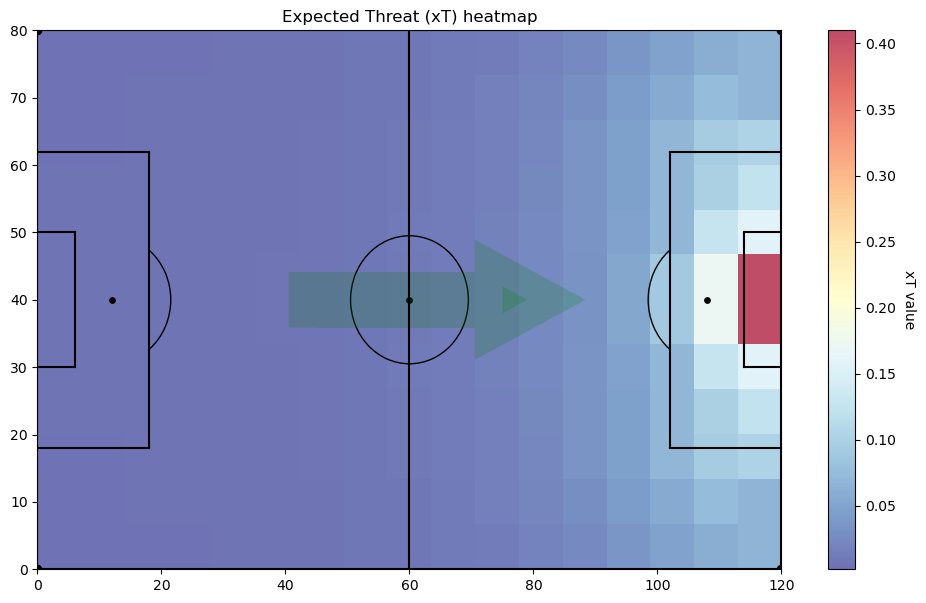

In [28]:
from field import plot_field

fig, ax = plt.subplots(figsize=(12, 7))
plot_field(ax)

# Plot the xT values
xT_values = np.flipud(xT_values)
im = ax.imshow(xT_values, extent=[0, 120, 0, 80], aspect='auto', cmap='RdYlBu_r', alpha=0.7)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('xT value', rotation=270, labelpad=15)
ax.arrow(45, 40, 30, 0, head_width=4, head_length=4, fc='green', ec='green', lw=40, alpha=0.2)
plt.title('Expected Threat (xT) heatmap')
plt.show()


In [29]:
events.loc[(events["pass.outcome.name"].isnull())& (events["type.name"] == "Pass"), "pass.outcome.name"] = "Complete"
events.loc[(events["pass.outcome.id"].isnull()) & (events["type.name"] == "Pass"), "pass.outcome.id"] = 8.

In [30]:
def get_outcome(row):
    if row["type.name"] == "Pass":
        return row["pass.outcome.name"]
    elif row["type.name"] == "Dribble":
        return row["dribble.outcome.name"]
    elif row["type.name"] == "Shot":
        return row["shot.outcome.name"]
    else:
        return None
    
events["outcome"] = events.apply(get_outcome, axis=1)

/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/4236249401.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events["outcome"] = events.apply(get_outcome, axis=1)


In [35]:
def get_end_location(row):
    if pd.notnull(row['pass.end_location']):
        return row['pass.end_location']

    elif pd.notnull(row['shot.end_location']):
        return row['shot.end_location']

    elif pd.notnull(row['carry.end_location']):
        return row['carry.end_location']

    elif row["type.name"] == "Dribble":
        # return end_location of next event
        row_index = row.name
        next_index = row_index + 1

        if next_index in events.index:  # Vérifie si le prochain index existe
            next_event = events.loc[next_index]
            return next_event.get("carry.end_location")
    else:
        return row['location']

def remove_brackets(x):
    if x[-1] == "]":
        return x[:-1]
    elif x[0] == "[":
        return x[1:]
    else:  
        return x

events['end_location'] = events.apply(get_end_location, axis=1)
events['end_x'] = events.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[0])) if pd.notnull(row['end_location']) else None, axis=1)
events['end_y'] = events.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[1])) if pd.notnull(row['end_location']) else None, axis=1)

events['end_z'] = events.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[-1])) if pd.notnull(row['end_location']) and row['type.name'] == 'Shot' else 0, axis=1)


events['xT.end'] = events.apply(lambda row: map_location_to_xT(row['end_x'], row['end_y'], xT_values) if pd.notnull(row['end_location']) else None, axis=1)

# cree une colonne xT.from qui est la valeur de xT de la ligne d'avant
events['xT.from'] = events['xT'].shift(1)

/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/2243670460.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['end_location'] = events.apply(get_end_location, axis=1)
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/2243670460.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['end_x'] = events.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[0])) if pd.notnull(row['end_location']) else None, axis=1)
/var/folders/hy/27t6v09s54x9lv_68y2

## OBV MODEL

## Create the possesion 2

In [40]:
events["possession_2"] = events["possession"].copy()

for i in events["possession_2"].unique():
    sub = events[events["possession_2"] == i]

    if "Shot" in sub["type.name"].unique() and sub["type.name"].value_counts()["Shot"] > 1:
        shot_part = sub[sub["type.name"] == "Shot"].index

        for idx in shot_part[:-1]:
            events.loc[idx+2:, "possession_2"] += 1

/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/3408636093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events["possession_2"] = events["possession"].copy()


## PSV

In [41]:
# Créer une colonne 'PSV' avec des valeurs par défaut de 0
events['PSVF'] = .0

for match in events['match_id'].unique():
    # Identifier les indices des tirs dans le dataframe
    shoot_indices = events[(events['type.name'] == 'Shot') & (events["match_id"] == match)].index

    # Calculer le PSV pour chaque séquence de possession
    for idx in shoot_indices:
        possession_idx = events.loc[idx, 'possession_2']
        possession_events = events[events['possession_2'] == possession_idx]

        # Calculer le PSV pour la séquence de possession
        total_xG = events.loc[idx]['shot.statsbomb_xg'].astype(float)
        events.loc[(events['possession_2'] == possession_idx) & (events["match_id"] == match ), 'PSVF'] = total_xG

/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/3173287008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['PSVF'] = .0


In [42]:
# Créer une colonne 'PSV' avec des valeurs par défaut de 0
events['PSVA'] = .0

for match in events['match_id'].unique():
    # Identifier les indices des tirs dans le dataframe
    shoot_indices = events[(events['type.name'] == 'Shot') & (events["match_id"] == match)].index
    prev_psv = 0
    for i, p in enumerate(events[events["match_id"] == match]["possession"].unique()):
        tmp_psvf = events.loc[(events['possession'] == p) & (events["match_id"] == match), 'PSVF']
        tmp_team = events.loc[(events['possession'] == p) & (events["match_id"] == match), 'possession_team.name']
        prev_team = tmp_team.iloc[0]
        prev_psv = tmp_psvf.iloc[0]
        if len(events.loc[(events["possession"] == p - 1) & (events["match_id"] == match), "PSVF"]) == 0:
            events.loc[(events["possession"] == p - 1) & (events["match_id"] == match), "PSVA"] = 0

        elif (events.loc[(events["possession"] == p - 1) & (events["match_id"] == match), "possession_team.name"].iloc[0]) == prev_team :
            events.loc[(events["possession"] == p - 1) & (events["match_id"] == match), "PSVA"] = 0
        else :
            events.loc[(events["possession"] == p - 1) & (events["match_id"] == match), "PSVA"] = prev_psv
            
        


/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/3192170126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['PSVA'] = .0


In [45]:
events[(events["type.name"] == "Duel")& (events["player.name"] == "Dayotchanculle Upamecano")][[ "minute", "type.name", "player.name", "PSVF", "PSVA", "xT", "xT.end", "rev_xT", "xT.from"]]

,minute,type.name,player.name,PSVF,PSVA,xT,xT.end,rev_xT,xT.from


## Model

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [49]:
events.fillna(0, inplace=True)

/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/2609749659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events.fillna(0, inplace=True)


In [50]:
## create a feature distance to goal
events['distance_to_goal'] = ((events['x'] - 120)**2 + (events['y'] - 40)**2)**0.5

## angle to goal (posts)
a2 = ((events['x'] - 120)**2 + (events['y'] - 40-3.66)**2)
c2 = ((events['x'] - 120)**2 + (events['y'] - 40 + 3.66)**2)
events['angle_to_goal'] = np.degrees(np.arccos((a2 + c2 - (7.3)**2)/(2*(a2**0.5)*(c2**0.5))))


/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/480205433.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events['distance_to_goal'] = ((events['x'] - 120)**2 + (events['y'] - 40)**2)**0.5
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_69903/480205433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['distance_to_goal'] = ((events['x'] - 120)**2 + (events['y'] - 40)**2)**0.5
/Users/thomassinapi/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning

In [75]:
# Select the columns to drop
column_name = events.columns[events.columns.str.endswith("name")]
end_location = events.columns[events.columns.str.endswith("end_location")]
to_drop = [*column_name, *end_location] + ["id", "index", "match_id", "match_date", "period", "player.id", "player.name",
                                           "substitution.replacement.id", "substitution.replacement.name",
                                           "match_outcome", "minute", "second", "possession", "possession_2",
                                           "competition_season", "timestamp", "half_start.late_video_start", "injury_stoppage.in_chain", "bad_behaviour.card.id",
                                           "tactics.lineup", "tactics.formation",
                                            "player.id", "pass.recipient.id",
                                           "related_events", "location", "PSVF", "shot.aerial_won", "PSVA",
                                           "shot.statsbomb_xg",
                                            "pass.shot_assist", "pass.goal_assist", "pass.assisted_shot_id"
                                           ]


# Select the features and the target
X = events.drop(to_drop, axis=1)
y = events["PSVF"]

# Transform the categorical variables into numerical variables
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = pd.Categorical(X[col]).codes

In [76]:
from xgboost import XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict the PSV
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.00320359437812637
R2 Score: 0.22206936819736833


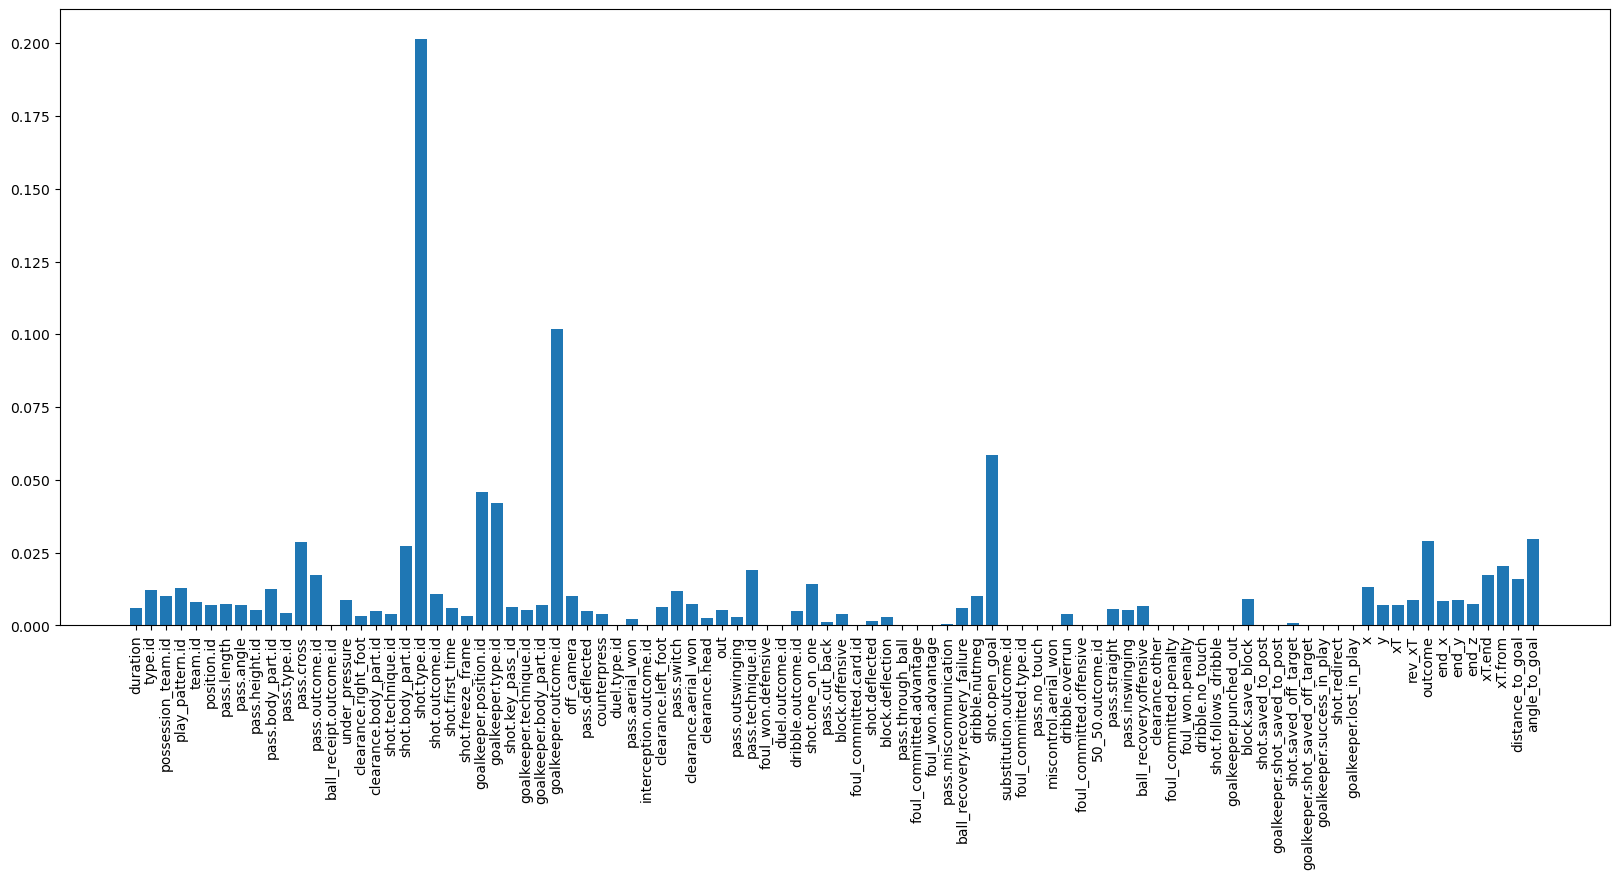

In [77]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

## Cross Validation

In [81]:
obv = model.predict(X)

In [84]:
r2_score(y, obv)

0.363704083947889

In [83]:
X["OBV"] = obv

In [91]:
events_obv = pd.concat([events, X], axis=1)

In [99]:
#somme des obv par joueurs 
obv_player = events_obv.groupby("player.name")["OBV"].sum().reset_index()

obv_player.sort_values(by="OBV", ascending=False).head(10)


,player.name,OBV
384,Lionel Andrés Messi Cuccittini,29.111044
543,Rodrigo Hernández Cascante,24.805357
544,Rodrigo Javier De Paul,22.691374
374,Kylian Mbappé Lottin,22.314493
316,Joshua Kimmich,20.445097
76,Aurélien Djani Tchouaméni,19.645334
510,Pedro González López,18.185289
488,Niklas Süle,17.204029
67,Antonio Rüdiger,16.662783
188,Enzo Fernandez,16.192062


## **<ins>Creation of the base dataset</ins>**

In [96]:
def extract_player_names(tactics_lineup):
    """
    Extract the names of the players from the tactics lineup
    
    Parameters:
    ----------
    tactics_lineup: list of dictionaries
        The list of players in the lineup

    Returns:
    -------
    list
        The list of players' names
    """
    return [player["player"]["name"] for player in tactics_lineup]

def extract_player_position(tactics_lineup):
    """
    Extract the position of the players from the tactics lineup

    Parameters:
    ----------
    tactics_lineup: list of dictionaries
        The list of players in the lineup

    Returns:
    -------
    list
        The list of players' positions
    """
    return [player["position"]["name"] for player in tactics_lineup]

In [97]:
# Extract the names of the players from the tactics lineup
lineup = events_obv[events_obv["type.name"] == "Starting XI"]

# Define the defensive players positions
defensive_players = ["Right Center Back", 
                     "Left Center Back", 
                     "Right Back", 
                     "Left Back",
                     "Center Back",
                     "Left Defensive Midfield", 
                     "Right Defensive Midfield", 
                     "Right Wing Back","Left Wing Back"]


# Create a cache to store player statistics
player_cache_appearances = {}
player_cache_clearance = {}
player_cache_keypass = {}
player_cache_assist = {}
player_cache_goals = {}

# Define the columns of the dataframe
columns = ["match_id", "competition_season", "match_date", "match_outcome"]
columns += [f"player_{i}" for i in range(1, 23)]

# Create a dataframe to store the starting XI
startingXI = pd.DataFrame(columns=columns)

In [133]:
# Iterate over each match date in the lineup dataframe
for match_date in lineup['match_date'].unique():
    # Get all events before the match date
    event_prev = events[events['match_date'] < match_date]

    # Get the lineup for the match date
    lineups_for_date = lineup[lineup["match_date"] == match_date]["tactics.lineup"]
    
    # Get the goals conceded by the goalkeepers
    goals_conceded = event_prev[(event_prev["goalkeeper.type.name"] == "Goal Conceded") | (event_prev["goalkeeper.type.name"] == "Penalty Conceded")]

    # Get the number of key passes and assists
    pass_ = (event_prev["type.name"] == "Pass")
    match_keypass = event_prev[pass_ & (event_prev["pass.assisted_shot_id"].notnull())]
    match_assists = event_prev[pass_ & (event_prev["pass.goal_assist"] == True)]

    # Get the number of Ball Recovery, Clearance and Blocks
    match_recovers = event_prev[(event_prev["type.name"] == "Ball Recovery")]
    match_clearance = event_prev[(event_prev["type.name"] == "Clearance")]
    match_blocks = event_prev[(event_prev["type.name"] == "Block")]

    # Get the number of duels won
    match_duels = event_prev[(event_prev["type.name"] == "Duel") & (event_prev["duel.outcome.name"] == "Won")]

    # Get the number of goals scored
    match_goals = event_prev[event_prev["shot.outcome.name"] == "Goal"]

    for tactics_lineup in lineups_for_date:
        #tactics_lineup = eval(tactics_lineup)
        player_names = extract_player_names(tactics_lineup)
        player_positions = extract_player_position(tactics_lineup)

        # Map the players to their positions
        player_to_position = dict(zip(player_names, player_positions))

        for player, position in player_to_position.items():
            # Get the number of appearances by the players
            player_cache_appearances[(player, match_date)] = event_prev[event_prev["player.name"] == player].groupby('match_id').first().reset_index().shape[0]
            
            # Get the number of assists and key passes by the players
            player_cache_assist[(player, match_date)] = match_assists[match_assists["player.name"] == player].shape[0]
            
            # Get the number of key passes by the players
            player_cache_keypass[(player, match_date)] = match_keypass[match_keypass["player.name"] == player].shape[0]
            
            # Store the number of goals conceded by the goalkeepers
            if position == "Goalkeeper":
                player_cache_goals[(player, match_date)] = goals_conceded[goals_conceded["player.name"] == player].shape[0]
            
            # Store the number of defensive actions by the players
            elif position in defensive_players:
                # Assign a weight to each defensive action
                clearance = match_clearance[match_clearance["player.name"] == player].shape[0] * .2
                blocks = match_blocks[match_blocks["player.name"] == player].shape[0] * .2
                recovers = match_recovers[match_recovers["player.name"] == player].shape[0] * .3
                duels = match_duels[match_duels["player.name"] == player].shape[0] * .3

                # Store the sum of all defensive actions
                player_cache_goals[(player, match_date)] = clearance + recovers + duels + blocks
            
            # Store the number of goals scored by the players
            elif not position in defensive_players:
                player_cache_goals[(player, match_date)] = match_goals[match_goals["player.name"] == player].shape[0]


In [134]:
# Reset the index of the starting XI dataframe
lineup.reset_index(drop=True, inplace=True)


In [135]:
for i in range(0, len(lineup), 2):
    # Extract the lineup for each team
    team1_lineup = lineup["tactics.lineup"][i]
    team2_lineup = lineup["tactics.lineup"][i + 1]

    # Check if the lineup is complete
    if len(team1_lineup) < 11 or len(team2_lineup) < 11:
        continue

    # Extract the names of the players from the tactics lineup
    player_names = extract_player_names(team1_lineup) + extract_player_names(team2_lineup)
    player_positions = extract_player_position(team1_lineup) + extract_player_position(team2_lineup)
    
    lineup_data = {
        "match_id": lineup["match_id"][i],
        "competition_season": lineup["competition_season"][i],
        "match_date": lineup["match_date"][i],
        "match_outcome": lineup["match_outcome"][i],

        **{f"player_{j+1}": player_names[j] for j in range(22)},

        **{f"player_{j+1}_position": player_positions[j] for j in range(22)},

        **{
            f"player_{j+1}_goals": (
                player_cache_goals.get((player_names[j], lineup["match_date"][i]), 0) /
                player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1)
                if player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1) != 0 else 0
            ) for j in range(22)
        },

        **{
            f"player_{j+1}_assists": (
                player_cache_assist.get((player_names[j], lineup["match_date"][i]), 0) /
                player_cache_appearances.get(
                    (player_names[j], lineup["match_date"][i]), 1)
                if player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1) != 0 else 0
            ) for j in range(22)
        },

        **{
            f"player_{j+1}_keypass": (
                player_cache_keypass.get((player_names[j], lineup["match_date"][i]), 0) /
                player_cache_appearances.get(
                    (player_names[j], lineup["match_date"][i]), 1)
                if player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1) != 0 else 0
            ) for j in range(22)
        }
    }

    startingXI = pd.concat([startingXI, pd.DataFrame([lineup_data])], ignore_index=True)

In [136]:
# Chargement du nouveau fichier
xi_wc_new = startingXI

# Extraction des noms de joueurs uniques
player_columns = [f'player_{i}' for i in range(1, 23)]
unique_players = xi_wc_new[player_columns].melt(value_name='Player')['Player'].unique()

# Création d'un DataFrame avec les noms des joueurs uniques
unique_players_df = pd.DataFrame(unique_players, columns=['Player'])

# Affichage du nombre de joueurs uniques et des premières lignes du nouveau DataFrame
(unique_players_df.shape[0], unique_players_df.head())
unique_players_df.rename(columns={'Player': 'player_full'}, inplace=True)
unique_players_df

,player_full
0,Vanja Milinković Savić
1,Damián Emiliano Martínez
2,Mathew Ryan
3,Alisson Ramsés Becker
4,Aymen Dahmen
...,...
515,Jonathan David
516,Gabriel Fernando de Jesus
517,Randal Kolo Muani
518,Haji Wright


In [137]:
stats_cleaned = df_normalized.drop_duplicates(subset=['Player'], keep='first')
stats_cleaned

,Player,Nation,Pos,Squad,Comp,90s,stat1,stat2,stat3
0,Max Aarons,ENG,DF,Norwich City,Premier League,32.0,0.275157,0.432000,0.597778
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,33.1,0.488994,0.374000,0.415556
2,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,27.4,0.287379,0.162222,0.240171
3,Laurent Abergel,FRA,MF,Lorient,Ligue 1,32.8,0.405825,0.223333,0.330769
4,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,0.5,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2916,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,28.8,0.357282,0.131111,0.358974
2917,Szymon ?urkowski,POL,MF,Empoli,Serie A,25.6,0.258252,0.260000,0.176923
2918,Martin Ødegaard,NOR,MF,Arsenal,Premier League,30.9,0.496117,0.482222,0.276923
2919,Milan ?uri?,BIH,FW,Salernitana,Serie A,24.1,0.146853,0.336170,0.204819


In [138]:
# Imaginons que vous avez deux DataFrames: unique_players_df et stats_cleaned
# avec les colonnes 'player_full' et 'Player' respectivement.

# Fonction pour vérifier si deux chaînes de caractères ont au moins deux mots en commun
def have_two_words_in_common(name1, name2):
    # Séparer les noms en mots, en enlevant les éventuels tirets
    words_name1 = set(name1.lower().replace("-", " ").split())
    words_name2 = set(name2.lower().replace("-", " ").split())
    
    # Compter le nombre de mots en commun
    common_words = words_name1.intersection(words_name2)
    
    # Vérifier si au moins deux mots sont en commun
    return len(common_words) >= 2

# Préparer une DataFrame pour la fusion
merged_rows = []

# Itérer sur chaque combinaison de lignes entre les deux DataFrames
for i, row1 in unique_players_df.iterrows():
    for j, row2 in stats_cleaned.iterrows():
        # Appliquer la fonction de vérification
        if have_two_words_in_common(row1['player_full'], row2['Player']):
            # Si correspondance, ajouter la combinaison des deux lignes à merged_rows
            merged_rows.append(row1.to_dict() | row2.to_dict())  # Utiliser l'union de dictionnaires (Python 3.9+)

# Convertir la liste des lignes fusionnées en DataFrame
merged_df = pd.DataFrame(merged_rows)

# Afficher le résultat
print(merged_df)


                    player_full             Player Nation   Pos  \
0      Damián Emiliano Martínez  Emiliano Martínez    ARG    GK   
1                   Mathew Ryan        Mathew Ryan    AUS    GK   
2                Yassine Bounou     Yassine Bounou    MAR    GK   
3                   Hugo Lloris        Hugo Lloris    FRA    GK   
4               Jordan Pickford    Jordan Pickford    ENG    GK   
..                          ...                ...    ...   ...   
254            Leandro Trossard   Leandro Trossard    BEL  FWMF   
255              Jonathan David     Jonathan David    CAN    FW   
256   Gabriel Fernando de Jesus      Gabriel Jesus    BRA    FW   
257           Randal Kolo Muani  Randal Kolo Muani    FRA  FWMF   
258  Álvaro Borja Morata Martín      Álvaro Morata    ESP    FW   

               Squad            Comp   90s     stat1     stat2     stat3  
0        Aston Villa  Premier League  36.0  0.000000  0.000000  0.000000  
1      Real Sociedad         La Liga   3.0  0

In [141]:
# Créer une copie de xi_wc_new pour ne pas modifier l'original pendant le processus
xi_wc_new_extended = startingXI.copy()

# Préparer les colonnes de statistiques pour chaque joueur dans xi_wc_new
for i in range(1, 23):  # Pour chaque joueur de player_1 à player_22
    player_column = f'player_{i}'
    # Créer les noms des colonnes pour les statistiques
    stat1_column = f'stat1_player_{i}'
    stat2_column = f'stat2_player_{i}'
    stat3_column = f'stat3_player_{i}'
    
    # Initialiser les colonnes de statistiques avec 0.0 (float) au lieu de 0 (int)
    xi_wc_new_extended[stat1_column] = moyenne_stat1
    xi_wc_new_extended[stat2_column] = moyenne_stat2
    xi_wc_new_extended[stat3_column] = moyenne_stat3
    
    # Pour chaque ligne dans xi_wc_new, chercher les statistiques du joueur correspondant dans merged_df
    for index, row in xi_wc_new_extended.iterrows():
        player_name = row[player_column]
        # Trouver le joueur dans merged_df
        player_stats = merged_df[merged_df['player_full'] == player_name]
        if not player_stats.empty:
            # Si le joueur est trouvé, mettre à jour les statistiques avec un cast explicite en float si nécessaire
            xi_wc_new_extended.at[index, stat1_column] = float(player_stats['stat1'].values[0])
            xi_wc_new_extended.at[index, stat2_column] = float(player_stats['stat2'].values[0])
            xi_wc_new_extended.at[index, stat3_column] = float(player_stats['stat3'].values[0])
        # Si le joueur n'est pas trouvé, les statistiques restent à 0.0 (déjà initialisées)

xi_wc_new_extended


,match_id,competition_season,match_date,match_outcome,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9,player_10,player_11,player_12,player_13,player_14,player_15,player_16,player_17,player_18,player_19,player_20,player_21,player_22,player_1_position,player_2_position,player_3_position,player_4_position,player_5_position,player_6_position,player_7_position,player_8_position,player_9_position,player_10_position,player_11_position,player_12_position,player_13_position,player_14_position,player_15_position,player_16_position,player_17_position,player_18_position,player_19_position,player_20_position,player_21_position,player_22_position,player_1_goals,player_2_goals,player_3_goals,player_4_goals,player_5_goals,player_6_goals,player_7_goals,player_8_goals,player_9_goals,player_10_goals,player_11_goals,player_12_goals,player_13_goals,player_14_goals,player_15_goals,player_16_goals,player_17_goals,player_18_goals,player_19_goals,player_20_goals,player_21_goals,player_22_goals,player_1_assists,player_2_assists,player_3_assists,player_4_assists,player_5_assists,player_6_assists,player_7_assists,player_8_assists,player_9_assists,player_10_assists,player_11_assists,player_12_assists,player_13_assists,player_14_assists,player_15_assists,player_16_assists,player_17_assists,player_18_assists,player_19_assists,player_20_assists,player_21_assists,player_22_assists,player_1_keypass,player_2_keypass,player_3_keypass,player_4_keypass,player_5_keypass,player_6_keypass,player_7_keypass,player_8_keypass,player_9_keypass,player_10_keypass,player_11_keypass,player_12_keypass,player_13_keypass,player_14_keypass,player_15_keypass,player_16_keypass,player_17_keypass,player_18_keypass,player_19_keypass,player_20_keypass,player_21_keypass,player_22_keypass,stat1_player_1,stat2_player_1,stat3_player_1,stat1_player_2,stat2_player_2,stat3_player_2,stat1_player_3,stat2_player_3,stat3_player_3,stat1_player_4,stat2_player_4,stat3_player_4,stat1_player_5,stat2_player_5,stat3_player_5,stat1_player_6,stat2_player_6,stat3_player_6,stat1_player_7,stat2_player_7,stat3_player_7,stat1_player_8,stat2_player_8,stat3_player_8,stat1_player_9,stat2_player_9,stat3_player_9,stat1_player_10,stat2_player_10,stat3_player_10,stat1_player_11,stat2_player_11,stat3_player_11,stat1_player_12,stat2_player_12,stat3_player_12,stat1_player_13,stat2_player_13,stat3_player_13,stat1_player_14,stat2_player_14,stat3_player_14,stat1_player_15,stat2_player_15,stat3_player_15,stat1_player_16,stat2_player_16,stat3_player_16,stat1_player_17,stat2_player_17,stat3_player_17,stat1_player_18,stat2_player_18,stat3_player_18,stat1_player_19,stat2_player_19,stat3_player_19,stat1_player_20,stat2_player_20,stat3_player_20,stat1_player_21,stat2_player_21,stat3_player_21,stat1_player_22,stat2_player_22,stat3_player_22
0,3857256,FIFA World Cup_2022,2022-12-02,-1,Vanja Milinković Savić,Nikola Milenković,Milos Veljkovic,Strahinja Pavlović,Andrija Živković,Filip Kostić,Saša Lukić,Sergej Milinković-Savić,Dušan Tadić,Dušan Vlahović,Aleksandar Mitrović,Gregor Kobel,Silvan Widmer,Fabian Lukas Schär,Manuel Obafemi Akanji,Ricardo Iván Rodríguez Araya,Remo Freuler,Granit Xhaka,Xherdan Shaqiri,Djibril Sow,Ruben Vargas,Breel-Donald Embolo,Goalkeeper,Right Center Back,Center Back,Left Center Back,Right Wing Back,Left Wing Back,Right Defensive Midfield,Left Defensive Midfield,Center Attacking Midfield,Right Center Forward,Left Center Forward,Goalkeeper,Right Back,Right Center Back,Left Center Back,Left Back,Right Defensive Midfield,Left Defensive Midfield,Right Wing,Center Attacking Midfield,Left Wing,Center Forward,2.500000,2.10,1.70,2.75,1.90,2.400000,2.40,3.6,0.000000,0.0,0.500000,0.000000,2.450000,0.000000,1.800000,1.950000,1.9,1.600000,0.000000,0.0,0.000000,0.5,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0,0.000000,0.000000,0.0,2.0,0.0,0.500000,0.0,0.5,0.000000,0.0,0.5,0.0,0.000000,1.000000,1.0,

In [142]:
# merge df aveec xi_wc_new_extended
startingXI = df_final_adjusted.merge(xi_wc_new_extended, on=["match_id", "match_date"], how="left")

In [143]:
startingXI

,match_id,home_team,away_team,xg_total_home,xg_total_away,match_date,home_score,away_score,home_form_xg,away_form_xg,home_adversary_xg,away_adversary_xg,home_form,away_form,competition_season,match_outcome,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9,player_10,player_11,player_12,player_13,player_14,player_15,player_16,player_17,player_18,player_19,player_20,player_21,player_22,player_1_position,player_2_position,player_3_position,player_4_position,player_5_position,player_6_position,player_7_position,player_8_position,player_9_position,player_10_position,player_11_position,player_12_position,player_13_position,player_14_position,player_15_position,player_16_position,player_17_position,player_18_position,player_19_position,player_20_position,player_21_position,player_22_position,player_1_goals,player_2_goals,player_3_goals,player_4_goals,player_5_goals,player_6_goals,player_7_goals,player_8_goals,player_9_goals,player_10_goals,player_11_goals,player_12_goals,player_13_goals,player_14_goals,player_15_goals,player_16_goals,player_17_goals,player_18_goals,player_19_goals,player_20_goals,player_21_goals,player_22_goals,player_1_assists,player_2_assists,player_3_assists,player_4_assists,player_5_assists,player_6_assists,player_7_assists,player_8_assists,player_9_assists,player_10_assists,player_11_assists,player_12_assists,player_13_assists,player_14_assists,player_15_assists,player_16_assists,player_17_assists,player_18_assists,player_19_assists,player_20_assists,player_21_assists,player_22_assists,player_1_keypass,player_2_keypass,player_3_keypass,player_4_keypass,player_5_keypass,player_6_keypass,player_7_keypass,player_8_keypass,player_9_keypass,player_10_keypass,player_11_keypass,player_12_keypass,player_13_keypass,player_14_keypass,player_15_keypass,player_16_keypass,player_17_keypass,player_18_keypass,player_19_keypass,player_20_keypass,player_21_keypass,player_22_keypass,stat1_player_1,stat2_player_1,stat3_player_1,stat1_player_2,stat2_player_2,stat3_player_2,stat1_player_3,stat2_player_3,stat3_player_3,stat1_player_4,stat2_player_4,stat3_player_4,stat1_player_5,stat2_player_5,stat3_player_5,stat1_player_6,stat2_player_6,stat3_player_6,stat1_player_7,stat2_player_7,stat3_player_7,stat1_player_8,stat2_player_8,stat3_player_8,stat1_player_9,stat2_player_9,stat3_player_9,stat1_player_10,stat2_player_10,stat3_player_10,stat1_player_11,stat2_player_11,stat3_player_11,stat1_player_12,stat2_player_12,stat3_player_12,stat1_player_13,stat2_player_13,stat3_player_13,stat1_player_14,stat2_player_14,stat3_player_14,stat1_player_15,stat2_player_15,stat3_player_15,stat1_player_16,stat2_player_16,stat3_player_16,stat1_player_17,stat2_player_17,stat3_player_17,stat1_player_18,stat2_player_18,stat3_player_18,stat1_player_19,stat2_player_19,stat3_player_19,stat1_player_20,stat2_player_20,stat3_player_20,stat1_player_21,stat2_player_21,stat3_player_21,stat1_player_22,stat2_player_22,stat3_player_22
0,3857256,Serbia,Switzerland,1.189004,3.103515,2022-12-02,2,3,1.901394,1.715174,4.194199,1.535803,-1,0,FIFA World Cup_2022,-1,Vanja Milinković Savić,Nikola Milenković,Milos Veljkovic,Strahinja Pavlović,Andrija Živković,Filip Kostić,Saša Lukić,Sergej Milinković-Savić,Dušan Tadić,Dušan Vlahović,Aleksandar Mitrović,Gregor Kobel,Silvan Widmer,Fabian Lukas Schär,Manuel Obafemi Akanji,Ricardo Iván Rodríguez Araya,Remo Freuler,Granit Xhaka,Xherdan Shaqiri,Djibril Sow,Ruben Vargas,Breel-Donald Embolo,Goalkeeper,Right Center Back,Center Back,Left Center Back,Right Wing Back,Left Wing Back,Right Defensive Midfield,Left Defensive Midfield,Center Attacking Midfield,Right Center Forward,Left Center Forward,Goalkeeper,Right Back,Right Center Back,Left Center Back,Left Back,Right Defensive Midfield,Left Defensive Midfield,Right Wing,Center Attacking Midfield,Left Wing,Center Forward,2.500000,2.10,1.70,2.75,1.90,2.400000,2.40,3.6,0.000000,0.0,0.500000,0.000000,2.450000,0.000000,1.800000,1.950000,1.9,1.600000,0.000000,0.0,0.00000

In [144]:
# # Encode the categorical columns
# enc = LabelEncoder()
# for col in startingXI.columns:
#     if col.endswith("position"):
#         startingXI[col] = enc.fit_transform(startingXI[col])
    
#     elif col.startswith("player"):
#         startingXI[col] = enc.fit_transform(startingXI[col])

# # Convert the match outcome to a binary variable
# startingXI["match_outcome"] = startingXI["match_outcome"].astype(int).apply(np.sign)

# # Store the starting XI dataframe
# startingXI.to_csv("startingXI.csv", index=False)
# startingXI.head()

In [145]:
startingXI

,match_id,home_team,away_team,xg_total_home,xg_total_away,match_date,home_score,away_score,home_form_xg,away_form_xg,home_adversary_xg,away_adversary_xg,home_form,away_form,competition_season,match_outcome,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9,player_10,player_11,player_12,player_13,player_14,player_15,player_16,player_17,player_18,player_19,player_20,player_21,player_22,player_1_position,player_2_position,player_3_position,player_4_position,player_5_position,player_6_position,player_7_position,player_8_position,player_9_position,player_10_position,player_11_position,player_12_position,player_13_position,player_14_position,player_15_position,player_16_position,player_17_position,player_18_position,player_19_position,player_20_position,player_21_position,player_22_position,player_1_goals,player_2_goals,player_3_goals,player_4_goals,player_5_goals,player_6_goals,player_7_goals,player_8_goals,player_9_goals,player_10_goals,player_11_goals,player_12_goals,player_13_goals,player_14_goals,player_15_goals,player_16_goals,player_17_goals,player_18_goals,player_19_goals,player_20_goals,player_21_goals,player_22_goals,player_1_assists,player_2_assists,player_3_assists,player_4_assists,player_5_assists,player_6_assists,player_7_assists,player_8_assists,player_9_assists,player_10_assists,player_11_assists,player_12_assists,player_13_assists,player_14_assists,player_15_assists,player_16_assists,player_17_assists,player_18_assists,player_19_assists,player_20_assists,player_21_assists,player_22_assists,player_1_keypass,player_2_keypass,player_3_keypass,player_4_keypass,player_5_keypass,player_6_keypass,player_7_keypass,player_8_keypass,player_9_keypass,player_10_keypass,player_11_keypass,player_12_keypass,player_13_keypass,player_14_keypass,player_15_keypass,player_16_keypass,player_17_keypass,player_18_keypass,player_19_keypass,player_20_keypass,player_21_keypass,player_22_keypass,stat1_player_1,stat2_player_1,stat3_player_1,stat1_player_2,stat2_player_2,stat3_player_2,stat1_player_3,stat2_player_3,stat3_player_3,stat1_player_4,stat2_player_4,stat3_player_4,stat1_player_5,stat2_player_5,stat3_player_5,stat1_player_6,stat2_player_6,stat3_player_6,stat1_player_7,stat2_player_7,stat3_player_7,stat1_player_8,stat2_player_8,stat3_player_8,stat1_player_9,stat2_player_9,stat3_player_9,stat1_player_10,stat2_player_10,stat3_player_10,stat1_player_11,stat2_player_11,stat3_player_11,stat1_player_12,stat2_player_12,stat3_player_12,stat1_player_13,stat2_player_13,stat3_player_13,stat1_player_14,stat2_player_14,stat3_player_14,stat1_player_15,stat2_player_15,stat3_player_15,stat1_player_16,stat2_player_16,stat3_player_16,stat1_player_17,stat2_player_17,stat3_player_17,stat1_player_18,stat2_player_18,stat3_player_18,stat1_player_19,stat2_player_19,stat3_player_19,stat1_player_20,stat2_player_20,stat3_player_20,stat1_player_21,stat2_player_21,stat3_player_21,stat1_player_22,stat2_player_22,stat3_player_22
0,3857256,Serbia,Switzerland,1.189004,3.103515,2022-12-02,2,3,1.901394,1.715174,4.194199,1.535803,-1,0,FIFA World Cup_2022,-1,Vanja Milinković Savić,Nikola Milenković,Milos Veljkovic,Strahinja Pavlović,Andrija Živković,Filip Kostić,Saša Lukić,Sergej Milinković-Savić,Dušan Tadić,Dušan Vlahović,Aleksandar Mitrović,Gregor Kobel,Silvan Widmer,Fabian Lukas Schär,Manuel Obafemi Akanji,Ricardo Iván Rodríguez Araya,Remo Freuler,Granit Xhaka,Xherdan Shaqiri,Djibril Sow,Ruben Vargas,Breel-Donald Embolo,Goalkeeper,Right Center Back,Center Back,Left Center Back,Right Wing Back,Left Wing Back,Right Defensive Midfield,Left Defensive Midfield,Center Attacking Midfield,Right Center Forward,Left Center Forward,Goalkeeper,Right Back,Right Center Back,Left Center Back,Left Back,Right Defensive Midfield,Left Defensive Midfield,Right Wing,Center Attacking Midfield,Left Wing,Center Forward,2.500000,2.10,1.70,2.75,1.90,2.400000,2.40,3.6,0.000000,0.0,0.500000,0.000000,2.450000,0.000000,1.800000,1.950000,1.9,1.600000,0.000000,0.0,0.00000

In [159]:
X = startingXI.drop(columns=["match_id", "competition_season", "match_date", "match_outcome", "home_team", "away_team", "home_score", "away_score", "xg_total_home","xg_total_away"])
y = startingXI["match_outcome"]
# Encode the categorical columns

enc = LabelEncoder()
for col in X.columns:
    if col.endswith("position"):
        X[col] = enc.fit_transform(X[col])
    
    elif col.startswith("player"):
        X[col] = enc.fit_transform(X[col])

y = y.apply(np.sign)
 

y = y.astype(int)

In [181]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=7)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)


In [182]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.46153846153846156


In [183]:
y_test.shape

(13,)